API Documentation: https://rapidapi.com/fkal094tiokg09w3vi095i/api/Airbnb%20Scraper%20API

In [4]:
## Before, make sure that the GCP libraries are installed

## pip install google
## pip install google.cloud
## pip install google.cloud.bigquery
## pip install google.cloud.storage
## pip install datetime, timedelta
## pip install pandas
## pip install db-dtypes

In [5]:
## Importing libraries to execute querying on BigQuery

from google.cloud import bigquery
from google.oauth2 import service_account
import personal_env as penv

In [6]:
## Importing Credentials from Google Cloud

CREDENTIALS = service_account.Credentials.from_service_account_file(penv.bq_path)
BIGQUERY = bigquery.Client(credentials=CREDENTIALS)

This section aims to create automated variables to perform the scrapping more sustainably

In [7]:
## Creating check-in and check-out variables

from datetime import datetime, timedelta
import pandas as pd

currentDate =  datetime.today()

## Creating list to save CheckIn and Checkout combinations

checkInAndOutDates = [
        {'checkin': (currentDate + timedelta(days=30)).strftime('%Y-%m-%d'), 
         'checkout': (currentDate + timedelta(days=60)).strftime('%Y-%m-%d')
        },
        #{'checkin': (currentDate + timedelta(days=60)).strftime('%Y-%m-%d'), 
         #'checkout': (currentDate + timedelta(days=90)).strftime('%Y-%m-%d')
        #},
        ##{'checkin': (currentDate + timedelta(days=90)).strftime('%Y-%m-%d'), 
        ## 'checkout': (currentDate + timedelta(days=120)).strftime('%Y-%m-%d')
        ##}
    ]


In [8]:
## Creating location variables 
## Query collecting Tabas Operating Neighbourhoods

sql =  """
        SELECT 
            DISTINCT CONCAT(city, ', ', neighborhood) AS city_and_neighbourhood_search
        FROM `tabas-dw.master_data.dim_tabas_buildings_and_apartments`
        LIMIT 1
        """

In [9]:
## Creating dataframe neighbourhoods to write the results

neighbourhoods = BIGQUERY.query(sql).result().to_dataframe()
neighbourhoods = neighbourhoods.values.tolist()

/home/tabas/.local/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


This sections aims to make a GET Request to the Airbnb Scraper API

In [10]:
## Creating dataframe df to write the following loop results

df = pd.DataFrame(columns=['badges'
                           , 'coordinates'
                            , 'id'
                            , 'images'
                            , 'price'
                            , 'rating'
                            , 'reviews'
                            , 'roomTitle'
                            , 'roomType'
                            , 'subTitle'
                            , 'title'
                            , 'url'
                            , 'location'
                            , 'checkin'
                            , 'checkout'
                            , 'adults'
                            , 'scrappedPage'
                            , 'extractionTimestamp'
                        ])

In [11]:
import requests
import pandas as pd
import json

## Define the variables to access Airbnb Scraper API

url = "https://airbnb-scraper-api.p.rapidapi.com/airbnb_search_stays_v2"

headers = {
    'x-rapidapi-key': penv.rapidapi_key,
    'x-rapidapi-host': "airbnb-scraper-api.p.rapidapi.com"
}


for i in range(len(neighbourhoods)):

    for j in range(len(checkInAndOutDates)):

        ## The cursor is an unique indicator of the page, this helps the API to know which page to scrap next
        ## It is re-set no None on a new request

        cursor = None
        hasNextPage = True

        ## Creating the following dataframe to follow-up the amount of pages scrapped
        ## It is re-set to empty on a new request

        cursorDataFrame = []

        ## The following parameter estipulates the limit amount of pages to be scrapped
        ## , if desired

        pageLimitation = 20

        while hasNextPage and len(cursorDataFrame) < pageLimitation:
    
            querystring = {
                "location": neighbourhoods[i][0],                  # Desired location
                "checkIn": checkInAndOutDates[j]['checkin'],       # Check-in Date
                "checkOut": checkInAndOutDates[j]['checkout'],      # Check-out Date
                "adults": "2",                                      # Number of adults
                "roomType": "2",                                    # Type of Acommodation: Entire Space
                "cursor": cursor
            }

            ## Logging the location being sent to the request

            print("Getting Request: ", querystring)

            ## Send GET request to the API

            response = requests.get(url, headers=headers, params=querystring)

            ## Extract the JSON text data into the variable 'data'

            data = response.text

            ## Convert JSON into a Pandas Dataframe

            data = json.loads(data)
            extracted = pd.DataFrame.from_dict(data['data'])

            ## Setting the new cursor value to scrape the following page

            cursor = data['pageInfo']['endCursor']
            hasNextPage = data['pageInfo']['hasNextPage']

            ## Add the cursor result to the cursor dataframe

            cursorDataFrame.append(cursor)

            ## Create new columns on extracted DataFrame to append API variables

            extracted['location'] = neighbourhoods[i][0]
            extracted['checkin'] = checkInAndOutDates[j]['checkin']
            extracted['checkout'] = checkInAndOutDates[j]['checkout']
            extracted['adults'] = 2
            #extracted['roomType'] = 2     -> Information already exists on JSON
            extracted['scrappedPage'] = len(cursorDataFrame)
            extracted['extractionTimestamp'] = datetime.today().strftime('%Y-%m-%d %X')

            ## Add the result to the previous created Dataframe
            
            df = df = pd.concat([df, extracted])

            print("Successfully added API request to DataFrame")

        else:
            if len(cursorDataFrame) > 0:
                print("Sucessfully scraped ", len(cursorDataFrame), " pages")
            else: 
                print("Error on API request")

print("End of API request")


Getting Request:  {'location': 'São Paulo, Jardins', 'checkIn': '2025-02-22', 'checkOut': '2025-03-24', 'adults': '2', 'roomType': '2', 'cursor': None}
Successfully added API request to DataFrame
Getting Request:  {'location': 'São Paulo, Jardins', 'checkIn': '2025-02-22', 'checkOut': '2025-03-24', 'adults': '2', 'roomType': '2', 'cursor': 'eyJzZWN0aW9uX29mZnNldCI6MCwiaXRlbXNfb2Zmc2V0IjoxOCwidmVyc2lvbiI6MX0='}
Successfully added API request to DataFrame
Getting Request:  {'location': 'São Paulo, Jardins', 'checkIn': '2025-02-22', 'checkOut': '2025-03-24', 'adults': '2', 'roomType': '2', 'cursor': 'eyJzZWN0aW9uX29mZnNldCI6MCwiaXRlbXNfb2Zmc2V0IjozNiwidmVyc2lvbiI6MX0='}
Successfully added API request to DataFrame
Getting Request:  {'location': 'São Paulo, Jardins', 'checkIn': '2025-02-22', 'checkOut': '2025-03-24', 'adults': '2', 'roomType': '2', 'cursor': 'eyJzZWN0aW9uX29mZnNldCI6MCwiaXRlbXNfb2Zmc2V0Ijo1NCwidmVyc2lvbiI6MX0='}
Successfully added API request to DataFrame
Getting Request:  

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270 entries, 0 to 17
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   badges               242 non-null    object
 1   coordinates          270 non-null    object
 2   id                   270 non-null    object
 3   images               270 non-null    object
 4   price                270 non-null    object
 5   rating               270 non-null    object
 6   reviews              270 non-null    object
 7   roomTitle            270 non-null    object
 8   roomType             270 non-null    object
 9   subTitle             270 non-null    object
 10  title                270 non-null    object
 11  url                  270 non-null    object
 12  location             270 non-null    object
 13  checkin              270 non-null    object
 14  checkout             270 non-null    object
 15  adults               270 non-null    object
 16  scrappedPage  

This section focus on the Ingestion of the resulting DataFrame to a specific GCP Bucket.

In [13]:
## Importing Credentials from Google Cloud

from google.cloud import storage
STORAGE = storage.Client(credentials=CREDENTIALS)

In [14]:
# Acessing Bucket Path

bucket = STORAGE.get_bucket(penv.bucket_path)

In [40]:
## Writing Dataframe to Bucket folder with desired file format 
## Writting in CSV format

blob = bucket.blob(f"{penv.bucket_folder}/test_data.csv")
blob.upload_from_string(df.to_csv(), '/text/csv')

In [41]:
## Writting in Parquet format

blob = bucket.blob(f"{penv.bucket_folder}/test_data.parquet")
blob.upload_from_string(df.to_parquet(), '/text/plain')

In [42]:
## Writting in JSON format

blob = bucket.blob(f"{penv.bucket_folder}/test_data.json")
blob.upload_from_string(df.to_json(orient='table'), '/text/plain')

In [43]:
## Writting in ORC format

blob = bucket.blob(f"{penv.bucket_folder}/test_data.orc")
blob.upload_from_string(df.reset_index().to_orc(index=None), '/text/plain')

In [202]:
## Preparing dataframe to write in Avro format

# pip install fastavro

from fastavro import writer, parse_schema, reader

# Converting all columns to string, because Avro doesn't support object type

columns_to_convert = [  # Lista de colunas definidas no esquema Avro
    'badges', 'coordinates', 'id', 'images', 'price', 'rating', 
    'reviews', 'roomTitle', 'roomType', 'subTitle', 'title', 
    'url', 'location', 'checkin', 'checkout', 'adults', 
    'scrappedPage', 'extractionTimestamp'
]

df[columns_to_convert] = df[columns_to_convert].astype(str)

# Declaring dataframe schema

schema = {
    'name': 'test_data'
    , 'type': 'record'
    , 'fields': [
                    {'name': 'badges', 'type': 'string'}, 
                    {'name': 'coordinates', 'type': 'string'}, 
                    {'name': 'id', 'type': 'string'}, 
                    {'name': 'images', 'type': 'string'}, 
                    {'name': 'price', 'type': 'string'}, 
                    {'name': 'rating', 'type': 'string'}, 
                    {'name': 'reviews', 'type': 'string'}, 
                    {'name': 'roomTitle', 'type': 'string'}, 
                    {'name': 'roomType', 'type': 'string'}, 
                    {'name': 'subTitle', 'type': 'string'}, 
                    {'name': 'title', 'type': 'string'}, 
                    {'name': 'url', 'type': 'string'}, 
                    {'name': 'location', 'type': 'string'}, 
                    {'name': 'checkin', 'type': 'string'}, 
                    {'name': 'checkout', 'type': 'string'}, 
                    {'name': 'adults', 'type': 'string'}, 
                    {'name': 'scrappedPage', 'type': 'string'}, 
                    {'name': 'extractionTimestamp', 'type': 'string'}
                ]

}

parsed_schema = parse_schema(schema)
records = df.to_dict('records')

# Writing an Avro file on 'archive' directory

with open('archive/test_data.avro', 'wb') as out:
    writer(out, parsed_schema, records)

In [203]:
## Writting in Avro format

blob = bucket.blob(f"{penv.bucket_folder}/test_data.avro")
blob.upload_from_filename('archive/test_data.avro', '/text/plain')

Result:

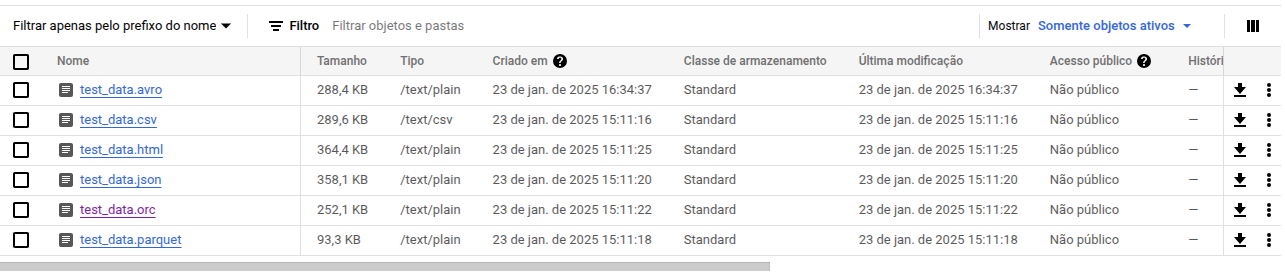

Próximos Passos:
- Entender possibilidades de Ingestão deste dataframe
- Transformar dataframe em delta table?
- Acrescentar biblioteca de log
- Criar funções para segregar as execuções